In [1]:
# # !python -m pip install -U spacy
# !python -m pip install -U spacy-lookups-data
# !python -m spacy download pt_core_news_sm
# # !python -m pip install -U unidecode
# # !python -m pip install -U tensorflow
# !wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s100.zip -O glove_s100.zip
# !unzip glove_s100.zip

## Content
    
    The tweets in the dataset were collected from Twitter mainly from 01/08/2018 to 20/10/2018.
    
    Training datasets:
    
    100k positive, negative and neutral tweets without any theme
    
    All of them have an equal number of instances between classes. Their sentiment labels were transformed as follow:
    
    Negative label: 0
    Positive label: 1
    Neutral  label: 2

## Import useful libraries and modules

In [2]:
%%time

import random
import re
import string
from unidecode import unidecode

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import RSLPStemmer
from nltk.stem.snowball import PortugueseStemmer

import spacy
from spacy.lang.pt import Portuguese

from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from pprint import pprint
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

print(tf.__version__)

# NLTK downloads
nltk.download('stopwords')
nltk.download('rslp')

2.3.1
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
CPU times: user 1.89 s, sys: 213 ms, total: 2.11 s
Wall time: 2.14 s


## Loading the data and performing exploratory data analyses (EDA)

In [3]:
%%time
# date_parser = lambda date: pd.to_datetime(date).tz_localize(None)
data = pd.read_csv('./Train3Classes.csv', sep=';', usecols=['tweet_text', 'sentiment'])
                #    index_col=['tweet_date']
                #    usecols=['tweet_date', 'tweet_text', 'sentiment'],
                #    parse_dates=True,
                #    date_parser=date_parser)

# Sort data
# data.sort_index(inplace=True)

# Label the target classes
data['sentiment'] = data['sentiment'].map({0: 'negative', 1: 'positive', 2: 'neutral'})

CPU times: user 160 ms, sys: 36.7 ms, total: 197 ms
Wall time: 197 ms


In [4]:
data.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o vale e azevedo :),positive
1,"@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)",positive
2,Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D,positive
3,"aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbIp7tRcSE",positive
4,"Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9",positive


In [5]:
# # Example
# x = "Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP"
# # Remove unicode characters
# x = x.encode('ascii', 'ignore').decode()
# x

In [6]:
original_shape = data.shape
print(f'This dataset has {data.shape[0]} rows and {data.shape[1]} columns')

This dataset has 100000 rows and 2 columns


In [7]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tweet_text  100000 non-null  object
 1   sentiment   100000 non-null  object
dtypes: object(2)
memory usage: 25.0 MB


In [8]:
data['sentiment'].value_counts(dropna=False)

positive    33334
negative    33333
neutral     33333
Name: sentiment, dtype: int64

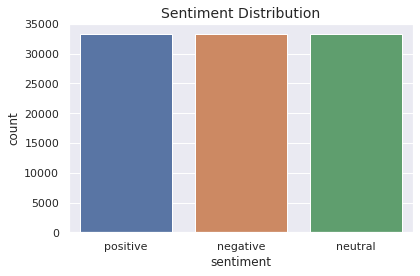

In [9]:
# Plot the sentimen distribution
sns.set()
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution', fontsize=14)
plt.tight_layout();

In [10]:
data['word_count'] = data['tweet_text'].apply(lambda row: len(row.strip().split()))

In [11]:
data.head(5)

,tweet_text,sentiment,word_count
0,@Laranjito76 A pessoa certa para isso seria o vale e azevedo :),positive,12
1,"@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)",positive,17
2,Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D,positive,34
3,"aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbIp7tRcSE",positive,24
4,"Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9",positive,35


In [12]:
# data.sort_values(by='word_count', ascending=False).head(7)

In [13]:

# Load SpaCY Portuguese model
nlp = Portuguese() 
# or spacy.load('pt_core_news_sm'), spacy.load('pt_core_news_md'), spacy.load('pt_core_news_lg')
# nlp = spacy.load('pt_core_news_md')

# Regular expressions
remove_urls     = re.compile(r'https?://\S+|www\.\S+')
remove_hashtags = re.compile(r'#')
remove_emails   = re.compile(r'\S+@\S+')
remove_rt       = re.compile(r'^RT[\s]+')
remove_numbers  = re.compile(r'\d+')

### Stop words
# Load Kaggle stop words
with open('./portugueseST.txt', 'r', encoding='latin-1') as words:
    kaggle_stop_words = [word.strip() for word in words]

# Load NLTK stop words
nltk_stop_words  = stopwords.words('portuguese')

# Load SpaCy stop words
spacy_stop_words = list(spacy.lang.pt.STOP_WORDS)

# Custom stop words
custom_stop_words = ['pra', 'to', 'vc', 'tá', 'pq', 'tô', 'ta', 'mt', 'pro',
                     'né', 'eh', 'tbm', 'ja', 'ah', 'vcs', 'hj', 'so',  'mto',
                     'agr', 'oq', 'la', 'tou', 'td', 'voce', 'ne', 'obg', 'tb']
                     # '\u200d', '\u200b', ] # 'oh',


### 'q', 'g', 'n', 'p', 'r', 'c', 'ª', 'i', '🏻', 'd', 'x', 'h', 'm', 'u', 'k', 's', 'º', 'b'

# All unique stop words
portuguese_stop_words = []
portuguese_stop_words.extend(kaggle_stop_words)
portuguese_stop_words.extend(nltk_stop_words)
portuguese_stop_words.extend(spacy_stop_words)
portuguese_stop_words.extend(custom_stop_words)
no_accented_stop_words = [unidecode(word) for word in portuguese_stop_words]
portuguese_stop_words.extend(no_accented_stop_words)
portuguese_stop_words.sort()
portuguese_stop_words = set(portuguese_stop_words)


# Load punctuation
# punctuation = string.punctuation.replace('@', '') + '-' + '—' + '‘' + '’' + '“' + '”' + "'" + '•'
punctuation = string.punctuation # .replace('@', '') + '-' + '—' + '‘' + '’' + '“' + '”' + "'" + '•'

# Instantiate TweetTokenizer
tt = TweetTokenizer(preserve_case=False,    # lowercasing
                    strip_handles=True,     # remove handles
                    reduce_len=True)     

def preprocess_text(text):

    # Parse HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # # Apply regex
    text = remove_urls.sub('', text)        # remove urls
    text = remove_hashtags.sub('', text)    # remove hashtags    
    text = remove_emails.sub('', text)      # remove e-mails
    text = remove_rt.sub('', text)          # remove RT
    text = remove_numbers.sub('', text)     # remove numbers 

    # text = text.encode('ascii', 'ignore').decode()

    # Remove punctuation
    # text = text.translate(text.maketrans('', '', punctuation)).strip()
    
    # Tokenize, lowercase, remove handles
    tokens = tt.tokenize(text)

    # Remove punctuation
    tokens = [word for word in tokens if word not in punctuation]

    # Transform accented words
    tokens = [unidecode(word) if word.isalpha() else word for word in tokens]

    # Remove unicode characters
    tokens = [word.encode('ascii', 'ignore').decode() for word in tokens]
    
    # Remove stop words    
    tokens = [word for word in tokens if word not in portuguese_stop_words]

    # Remove no alphabetical and single chars
    tokens = [word for word in tokens if word.isalpha() and len(word) > 1]

    # # NLTK SnowBall Portuguese stemmer
    # st = PortugueseStemmer()
    # tokens = [st.stem(word) for word in tokens]

    # NLTK RSLPStemmer Portuguese stemmer
    # st = RSLPStemmer()
    # tokens = [st.stem(word) for word in tokens]
    
    ## SpaCy
    # Normalize
    # text = ' '.join(tokens)
    # doc = nlp(text)
    
    # tokens = [token.norm_ for token in doc]

    # Lemmatization
    # text = ' '.join(tokens)
    # doc = nlp(text)
    
    # tokens = [token.lemma_ for token in doc if token.lemma_ not in portuguese_stop_words]  

    # # # Remove punctuation
    # text = ' '.join(str(word) for word in tokens)
    # # text = ' '.join(tokens)
    # text = text.translate(text.maketrans('', '', punctuation))  

    # return ' '.join(word.strip() for word in tokens)
    # return ' '.join(str(word) for word in tokens)    
    # return text
    return ' '.join(tokens)

In [14]:
data.sort_values(by='word_count', ascending=False).head(10)

,tweet_text,sentiment,word_count
27458,"@fp3po @etsblade @einsiderbr @MPBeSports @Memescblol @opkinoteam @AcerdoBrasil @windowsbr @blackdragonsBR @KaBuMESports @VivoKeyd @havanliberty @Akasabrasil @giganterichard @mawthg @_AiikaB @surskity @RedemptionPOA @INTZeSports @cariocAlol @dionrraylol @maisesportsbr @ESPNEsportsBR @VersusIGNBrasil @esportv @vaggasbr @gstv1lol @GruntarTV @R6BRatualizado @ZevaOficial @lunacydiego @MELAOtreze Opa @fp3po! QUE DIFÍCIL! Ta permitido levar pro lado dos animes? (Não vejo tantas séries ): )😭 Se tiver... - One Piece - Boku no Hero Academia - Hunter x Hunter - Shokugeki no Soma - Shingeki no Kyojin Alô amores, @_minorith @julyangelll @cprandoni @starswithnames",positive,77
27716,Te amo Te amo Te amo Te amo 💕💕 Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo Te amo @_HxrryCreature :) Las únicas fotos en las que realmente me sentí feliz https://t.co/pKdpaueMA2,positive,72
26527,@MiseryCop @GameComCiencia @TioChuckz @thiescayt @JogandoJuntas @AthenaGamerKJ @deeego @ferxnomath @shuberry @Drugue @sailorlunna @LizaMancuso @Confusiany @EricaRockCity @filipebaldin @kazzulo @cherlopes @jehssuda @SilasC92 @ramonminero @Kapiwara @forjadomestre @_psicopomp0 @KorraBook4 @leandropug @NikasPlay @_Ybl @NieleAElfa @VamosdeTres @gabrielli_v @gkyoji @NandaPlay @drikagamerbr @_kashmiir @KizumbbaPlay @Milhafre_Tuga @sandrigorn @Pesterenan @WooDInTheMachin @Sson7 @Leirnor @gsbressan @BrazilianBunny @salsatheone @rafaelschebuk 1. The Sopranos 2. True Detective 3. Vikings 4. Dexter 5. Mr Robot Prison Break e Heroes também :D Também não posso esquecer que deuses são reais..................,positive,72
64184,"@gabecrismar Sim, porém o iPhone 8 só tem d 64 a 256gb e a diferença é d mil reais entre eles, já o 7plus tem o d 128gb q seria ideal p mim, além dá câmera do 7plus ser mt top, principalmente naquela função do foco, q eu acho mara. E tem tb o designer e o tamanho e eu amo o tamanho do plus :(",negative,66
37742,"@KaderZera @cyb3rzera @MasterKingR6 @oretalha @canalzigueira @neskwga @JULIOAKAJULIO1 @Moska1m @NovysR6 @sensifps @xSexyCake @paulopsk1 @UbisoftBrasil @rainbow6br Mano, foi um dos motivos pra eu estar abandonando o game. Na ultima ss eu so fiz a md10 e parei, cheater por cima de cheater. Voltei a jogar cs mesmo, prefiro pegar um cheater em 1 partida a cada 10 do que 7/10 :( e a ubisoft nao faz nada",negative,65
98025,@MOBILIDADECOTIA @catracalivre @FaaAugusto @eduardopaulinos @sardinhaexpress @COMMU_Oficial @fefadaniel @sindpd @mundosindical @lauraabcarvalho @coisasdogeek @GeorgMarques @jovemnerd @RitaLisauskas @blogdosakamoto @zerotoledo @convergencia @Gledson_MA @_thalesnogueira @Cecillia @PatoCorporation @hamenteslivres @cartamaior @IvanValente @jserafim627 @revistavoto @chutandoaescada @revistaforum @AndreVicente9 @ODamazio @Alessan24907664 @g1 ⏫⏬ Olha! Tem a #inflação de rico! Até p/ele 💸 ! 📲 https://t.co/2POKvkUMbo 💻 #emprego #trabalho #desemprego #previdencia #INSS #dinheiro #salario #economia #poupanca #alta #reajuste #preço #inflação #Eleicoes2018 sem #grana https://t.co/DkcffQRxtI,neutral,63
47782,"eu amo muito a hyejoo sério é incontrolável o que eu sinto por ela, a extensão de amor que ela me faz sentir é algo que eu fico pasma só de sentir e eu amo ela mais que tudo neste universo. ela é minha paz, meu lugar de aconchego e eu não sei o que faria sem uma vida sem ela :( https://t.co/CUhBkFo6wa",negative,63
21462,"Hoje em dia, se você não faz algo que a pessoa quer ela já de mimimi, só porque aos olhos DELA você não agradou ... tenho vontade e de matar pessoas assim, a gente faz de um T U D O . Pra no final receber isso . Espero que vc vá tomar no olho do seu cu :) arrombada. Te odeio. [;",positive,63
57074,"@breatrhin @Bkstg o vinil eu nunca achei tb não mana nem sem ser pelo bkstg, só o cd que um amigo meu q tem uma irmã que mora no japão que me arruma e tals eu estava até vendend

In [15]:
%%time
print(
    preprocess_text(data.loc[27458, 'tweet_text']),
    preprocess_text(data.loc[27716, 'tweet_text']),
    preprocess_text(data.loc[26527, 'tweet_text']),
    preprocess_text(data.loc[64184, 'tweet_text']),
    preprocess_text(data.loc[37742, 'tweet_text']),
    preprocess_text(data.loc[98025, 'tweet_text']),
    preprocess_text(data.loc[47782, 'tweet_text']),
    preprocess_text(data.loc[21462, 'tweet_text']),
    preprocess_text(data.loc[57074, 'tweet_text']),
    preprocess_text(data.loc[57324, 'tweet_text']),
    
    sep='\n\n',
)

opa dificil permitido levar animes vejo tantas series one piece boku hero academia hunter hunter shokugeki soma shingeki kyojin alo amores

amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo amo las unicas fotos en las realmente senti feliz

the sopranos true detective vikings dexter mr robot prison break heroes esquecer deuses reais

iphone gb diferenca reais plus gb ideal mim camera plus top principalmente funcao foco acho mara designer tamanho amo tamanho plus

mano motivos abandonando game ultima ss fiz md parei cheater cheater voltei jogar cs prefiro cheater partida ubisoft

olha inflacao rico emprego desemprego previdencia inss dinheiro salario economia poupanca alta reajuste preco inflacao eleicoes grana

amo hyejoo serio incontrolavel sinto extensao amor sentir fico pasma sentir amo universo paz aconchego faria vida

pessoa mimimi olhos agradou vontade matar pessoas gente receber espero va tomar olho cu arrombada odei

In [16]:
# %%time
# print(
#     preprocess(data.loc['2018-09-27 22:07:09', 'tweet_text']),
#     preprocess(data.loc['2018-09-27 23:05:00', 'tweet_text']),
#     preprocess(data.loc['2018-09-27 21:51:37', 'tweet_text']),
#     preprocess(data.loc['2018-09-30 04:00:37', 'tweet_text']),
#     preprocess(data.loc['2018-10-08 12:40:35', 'tweet_text'][1]),
#     preprocess(data.loc['2018-10-01 15:10:56', 'tweet_text']),
#     preprocess(data.loc['2018-08-24 01:40:10', 'tweet_text']),
#     preprocess(data.loc['2018-10-01 14:14:25', 'tweet_text']),
#     preprocess(data.loc['2018-10-02 03:30:14', 'tweet_text']),
#     preprocess(data.loc['2018-09-04 20:20:40', 'tweet_text']),

#     sep='\n\n',
# )


In [17]:
%%time
# data['text'] = data['tweet_text'].apply(preprocess_text)
data['text'] = data['tweet_text'].apply(preprocess_text)

CPU times: user 16.2 s, sys: 291 ms, total: 16.5 s
Wall time: 16.3 s


In [18]:
data['word_count'] = data['text'].apply(lambda row: len(row.strip().split()))

In [19]:
data.head()

,tweet_text,sentiment,word_count,text
0,@Laranjito76 A pessoa certa para isso seria o vale e azevedo :),positive,4,pessoa certa vale azevedo
1,"@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)",positive,5,mim precisamente contrario chuva disposicao
2,Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D,positive,13,vou video pensando falar meta csgo pagina alguem sugestao queria falar cenario nacional
3,"aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbIp7tRcSE",positive,10,aaa amei polaroids expressar apaixonada vdd espero pessoas consigam ganhar
4,"Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9",positive,10,valoriza coracao menininho diferente faca sorrir valorizo mundo vida diferente


In [20]:
# data.loc[data['text'].str.contains(r'\scv\s|\bcv\b', regex=True)]

In [21]:
text = ' '.join(data['text'])
freq_dist = nltk.FreqDist(TweetTokenizer().tokenize(text))
print(len(freq_dist))
print('---\n')
# pprint(freq_dist.most_common(1000), compact=True)
pprint(freq_dist.most_common(35), compact=True)

59715
---

[('fato', 3862), ('vou', 3587), ('bolsonaro', 3534), ('queria', 3067),
 ('oportunidade', 2854), ('gente', 2378), ('eleicoes', 2151), ('emprego', 2108),
 ('triste', 2028), ('amo', 1892), ('brasil', 1860), ('vaga', 1782),
 ('sp', 1627), ('haddad', 1593), ('vida', 1539), ('melhor', 1530),
 ('pessoas', 1510), ('noticia', 1421), ('acho', 1390), ('mim', 1365),
 ('mundo', 1355), ('feliz', 1313), ('amor', 1313), ('casa', 1280),
 ('kkk', 1238), ('ficar', 1223), ('ciro', 1165), ('semana', 1157),
 ('turno', 1153), ('alguem', 1125), ('fake', 1123), ('novidade', 1103),
 ('pt', 1099), ('paulo', 1091), ('deus', 1052)]


In [22]:
# print(len(portuguese_stop_words))
# print('---\n')
# pprint(sorted(portuguese_stop_words), compact=True)

In [23]:
# wordcloud = WordCloud(background_color='black',                      
#                     #   width=1000,
#                     #   height=1000,
#                       max_words=5_000,
#                     #   collocations=False,
#                     #   stopwords={'não', 'eh', 'série', 'temporada', 'oq'},
#                       random_state=0).generate_from_frequencies(freq_dist)

# fig = plt.figure(figsize=[10, 10])
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.tight_layout()
# plt.axis("off")
# plt.show()

In [24]:
# data['word_count'] = data['text'].apply(lambda row: len(row.strip().split()))

In [25]:
data[data['text'].str.contains(r'\d+', regex=True)]

,tweet_text,sentiment,word_count,text


## SpaCy Lemmatization

In [26]:
# %%time
# # Instatiate Spacy pretrained statistical models for Portuguese
# nlp = spacy.load('pt_core_news_sm')
# # from spacy.lang.pt import Portuguese
# # nlp = Portuguese()

# # Lammatization
# data['text'] = [' '.join(word.lemma_ for word in nlp(sentence)) for sentence in tqdm(data['text'])]

In [27]:
# for sentence in data['text'].sample(10):
#     # print(sentence)
#     doc = nlp(str(sentence))
#     print([word.text for word in doc])
#     print([word.pos_ for word in doc])
#     print([word.norm_ for word in doc]) # , '---\n', sep='\n')
#     print(' '.join(word.lemma_ for word in doc), '---\n', sep='\n')

    

In [28]:
data.head()

,tweet_text,sentiment,word_count,text
0,@Laranjito76 A pessoa certa para isso seria o vale e azevedo :),positive,4,pessoa certa vale azevedo
1,"@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)",positive,5,mim precisamente contrario chuva disposicao
2,Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D,positive,13,vou video pensando falar meta csgo pagina alguem sugestao queria falar cenario nacional
3,"aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbIp7tRcSE",positive,10,aaa amei polaroids expressar apaixonada vdd espero pessoas consigam ganhar
4,"Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9",positive,10,valoriza coracao menininho diferente faca sorrir valorizo mundo vida diferente


## Handling missing data

In [29]:
print(data.shape, '---', sep='\n')
display(data.loc[data['word_count'] == 0].head())

(100000, 4)
---


,tweet_text,sentiment,word_count,text
47,@claaract_ De nada! :),positive,0,
58,@WeLovesT3ddy Obrigada!!! :),positive,0,
62,Está tudo bem :),positive,0,
75,NÃO FAÇO MAIS QUESTÃO :),positive,0,
81,@animal_slb @EPlurCorruptum @xiquinhorabeta @HugoGil07 @boloposte Nem mais :),positive,0,


In [30]:
data.loc[data['word_count'] == 0, ['text']] = np.nan
print(data.isna().sum())

tweet_text       0
sentiment        0
word_count       0
text          2454
dtype: int64


In [31]:
data.dropna(inplace=True)
print(data.isna().sum())
print('---')
print(data.shape)

tweet_text    0
sentiment     0
word_count    0
text          0
dtype: int64
---
(97546, 4)


In [32]:
# ?nltk.FreqDist

In [33]:
text = ' '.join(data['text'])
freq_dist = nltk.FreqDist(TweetTokenizer().tokenize(text))
print(len(freq_dist))
print('---\n')
# pprint(freq_dist.most_common(1000), compact=True)
pprint(freq_dist.most_common(35), compact=True)

59715
---

[('fato', 3862), ('vou', 3587), ('bolsonaro', 3534), ('queria', 3067),
 ('oportunidade', 2854), ('gente', 2378), ('eleicoes', 2151), ('emprego', 2108),
 ('triste', 2028), ('amo', 1892), ('brasil', 1860), ('vaga', 1782),
 ('sp', 1627), ('haddad', 1593), ('vida', 1539), ('melhor', 1530),
 ('pessoas', 1510), ('noticia', 1421), ('acho', 1390), ('mim', 1365),
 ('mundo', 1355), ('feliz', 1313), ('amor', 1313), ('casa', 1280),
 ('kkk', 1238), ('ficar', 1223), ('ciro', 1165), ('semana', 1157),
 ('turno', 1153), ('alguem', 1125), ('fake', 1123), ('novidade', 1103),
 ('pt', 1099), ('paulo', 1091), ('deus', 1052)]


In [34]:
rare_words = [word for word, freq in freq_dist.items() if freq == 1]
print(f'Total de palavras únicas: {len(freq_dist)}')
print(f'Total de palavras raras.: {len(rare_words)}')

Total de palavras únicas: 59715
Total de palavras raras.: 29918


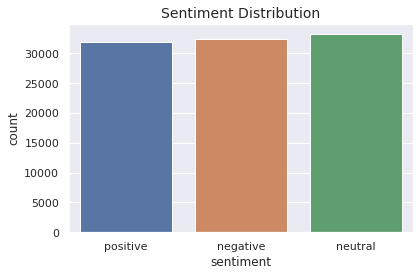

In [35]:
# Plot the sentimen distribution
sns.set()
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution', fontsize=14)
plt.tight_layout();

In [36]:
# %%time
# data['text'] = data['text'].apply(lambda row: ' '.join([word for word in row.split() if word not in rare_words]))

## Training and validating the model

In [37]:
data_reduced = data.loc[data['word_count'] > 4]

reduction = (original_shape[0] - data_reduced.shape[0]) / original_shape[0]
print(f'redução de {reduction:.2%} em relação aos dados originais')

redução de 42.05% em relação aos dados originais


In [38]:
X = data_reduced.loc[:, ['text', 'word_count']]
y = data_reduced['sentiment'].values

# X = data.loc[:, ['text', 'word_count']]
# y = data['sentiment'].values

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((46357, 2), (46357,), (11590, 2), (11590,))

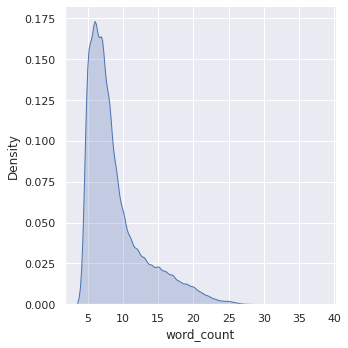

In [40]:
# # Updata the "word_count" column
data['word_count'] = data['text'].apply(lambda row: len(row.split()))

sns.set()
bins=len(set(X_train['word_count']))
sns.displot(x='word_count', data=X_train, kind='kde', fill=True) # ) #, bins=bins)
# sns.displot(x='word_count', data=X_train, bins=bins)
plt.tight_layout();

In [41]:
params = {
    'tokenizer': {'num_words': None, 'oov_token': '<UNK>'},
    'pad_sequences': {'maxlen': 30, 'padding': 'post', 'truncating': 'post'},
}

tokenize = Tokenizer(**params['tokenizer'])
tokenize.fit_on_texts(X_train['text'])
word_index = tokenize.word_index

X_train_seq = tokenize.texts_to_sequences(X_train['text'])
X_train_pad = pad_sequences(X_train_seq, **params['pad_sequences'])

X_test_seq  = tokenize.texts_to_sequences(X_test['text'])
X_test_pad  = pad_sequences(X_test_seq, **params['pad_sequences'])

## Preparing labels

In [42]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

target_names = le.classes_

In [43]:
X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape, len(word_index), target_names

((46357, 30),
 (46357,),
 (11590, 30),
 (11590,),
 48121,
 array(['negative', 'neutral', 'positive'], dtype=object))

In [44]:
# %%time
# tf.keras.backend.clear_session()
# tf.random.set_seed(0)
# np.random.seed(0)

# vocab_size = len(word_index) + 1
# embedding_dim = 32

# classifier = tf.keras.models.Sequential([
#              tf.keras.layers.Embedding(vocab_size,
#                                        embedding_dim, 
#                                        input_length=X_train_pad.shape[1]),
#              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
#                                                                 # dropout=0.25,
#                                                                 # recurrent_dropout=0.25)
#                                                                 ),
#              tf.keras.layers.Dense(3, activation='softmax'),
# ])

# classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-1),
#                    loss='sparse_categorical_crossentropy',
#                    metrics=['accuracy'])

# classifier.summary()

In [45]:
# %%time

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

# batch_size = 128
# history = classifier.fit(X_train_pad,
#                          y_train,
#                          batch_size=batch_size, 
#                          epochs=100, 
#                          validation_split=0.2, 
#                          callbacks=[lr_schedule], 
#                          workers=4, 
#                          use_multiprocessing=True,
#                          verbose=1);

In [46]:
# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-6, 1e-1, 0, 1.25])

In [47]:
# lr_hist = pd.DataFrame(history.history)
# lr_hist.head(4)

In [48]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# sns.lineplot(x='lr', y='loss', data=lr_hist, ax=ax[0])
# ax[0].set(xlabel='Learning rate')
# sns.lineplot(x='lr', y='loss', data=lr_hist, ax=ax[1])
# ax[1].set(xscale='log', xlabel='Learning rate')
# ax[1].axvline(1.7e-2, color='g', linestyle='--', linewidth=1)
# ax[1].axhline(lr_hist['loss'].min(), color='r', linestyle='--', linewidth=1)
# plt.tight_layout();

In [49]:
# help(tf.keras.callbacks.ReduceLROnPlateau)

In [50]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_accuracy',    
                                         patience=4,
                                         factor=0.5,
                                         mode='max',
                                         verbose=1),

    tf.keras.callbacks.EarlyStopping('val_accuracy', 
                                     patience=10,
                                     verbose=1,
                                     mode='max',
                                     restore_best_weights=True),
]

In [72]:

random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
tf.keras.backend.clear_session()

vocab_size =  len(word_index) + 1 # params['tokenizer']['num_words']
embedding_dim = 128

classifier = tf.keras.models.Sequential([
             tf.keras.layers.Embedding(vocab_size,
                                       embedding_dim, 
                                       # weights=[embeddings_matrix], trainable=False,
                                       input_length=X_train_pad.shape[1]),
            # tf.keras.layers.GRU(embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), # , dropout=0.5, recurrent_dropout=0.5)), # dropout=0.4, recurrent_dropout=0.4, return_sequences=True)),
            #  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.4, recurrent_dropout=0.4)),  #, dropout=0.1, recurrent_dropout=0.1)), # )),
            #  tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
            #  tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same'),

                                                                # dropout=0.25,
                                                                # recurrent_dropout=0.25)), # dropout=0.25, recurrent_dropout=0.25
             tf.keras.layers.Dense(64, activation='relu'),
             tf.keras.layers.Dense(3, activation='softmax'),
])

lr = 1e-2
classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 128)           6159616   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 6,439,427
Trainable params: 6,439,427
Non-trainable params: 0
_________________________________________________________________


In [73]:
%%time
history = classifier.fit(X_train_pad,
                         y_train,
                         batch_size=64, 
                         epochs=100, 
                         validation_split=0.2, 
                         callbacks=callbacks, 
                         workers=4, 
                         use_multiprocessing=True);

Epoch 1/100
580/580 [==============================] - 171s 295ms/step - loss: 0.4862 - accuracy: 0.7871 - val_loss: 0.4034 - val_accuracy: 0.8307
Epoch 2/100
580/580 [==============================] - 169s 292ms/step - loss: 0.2393 - accuracy: 0.9023 - val_loss: 0.4776 - val_accuracy: 0.8247
Epoch 3/100
580/580 [==============================] - 167s 287ms/step - loss: 0.1409 - accuracy: 0.9457 - val_loss: 0.6019 - val_accuracy: 0.8176
Epoch 4/100
580/580 [==============================] - 164s 283ms/step - loss: 0.1055 - accuracy: 0.9610 - val_loss: 0.7678 - val_accuracy: 0.8083
Epoch 5/100
580/580 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9628
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
580/580 [==============================] - 166s 286ms/step - loss: 0.0993 - accuracy: 0.9628 - val_loss: 0.8918 - val_accuracy: 0.8034
Epoch 6/100
580/580 [==============================] - 167s 288ms/step - loss: 0.0834 - accuracy: 0.9

In [74]:
hist = pd.DataFrame(history.history)

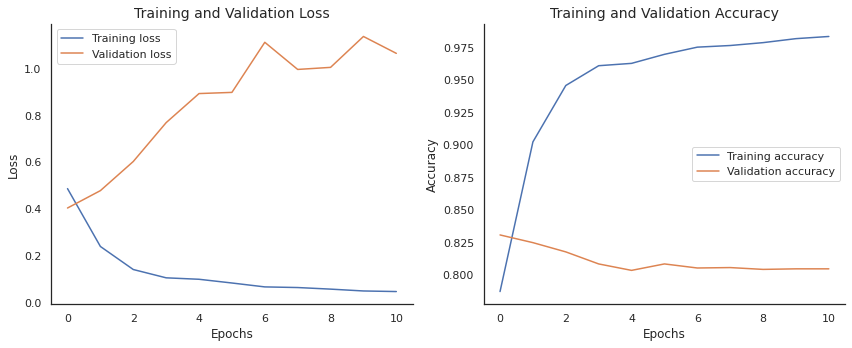

In [75]:
sns.set(style='white')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=hist.index, y='loss', data=hist, label='Training loss', ax=ax[0])
sns.lineplot(x=hist.index, y='val_loss', data=hist, label='Validation loss', ax=ax[0])

ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Training and Validation Loss', fontsize=14)

sns.lineplot(x=hist.index, y='accuracy', data=hist, label='Training accuracy', ax=ax[1])

sns.lineplot(x=hist.index, y='val_accuracy', data=hist, label='Validation accuracy', ax=ax[1])

ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].set_title('Training and Validation Accuracy', fontsize=14)

sns.despine()             
plt.tight_layout();

In [76]:
_, accuracy = classifier.evaluate(X_test_pad, y_test, batch_size=1024, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 83.07%


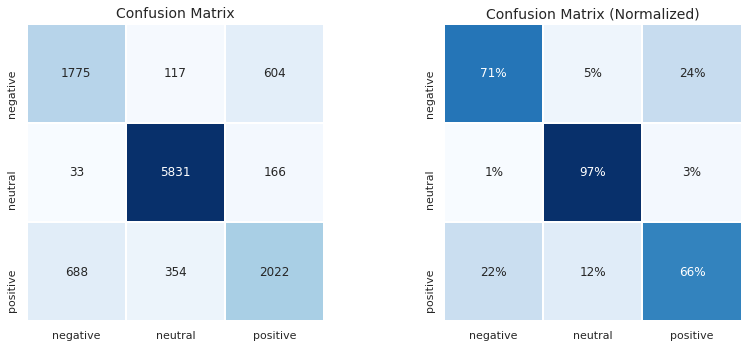

In [77]:
preds = np.argmax(classifier.predict(X_test_pad, batch_size=1024), axis=1)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, preds),
            cmap='Blues',
            center=None,
            annot=True,
            fmt='d',
            linewidths=1,
            cbar=False,
            square=True,
            xticklabels=target_names,
            yticklabels=target_names,
            ax=ax[0])
            
ax[0].set_title('Confusion Matrix', fontsize=14)    

sns.heatmap(confusion_matrix(y_test, preds, normalize='true'),
            cmap='Blues',
            center=None,
            annot=True,
            fmt='.0%',
            linewidths=1,
            cbar=False,
            square=True,
            xticklabels=target_names,
            yticklabels=target_names,
            ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized)', fontsize=14) 

plt.tight_layout();

In [78]:
print(classification_report(y_test, preds, target_names=target_names));

              precision    recall  f1-score   support

    negative       0.71      0.71      0.71      2496
     neutral       0.93      0.97      0.95      6030
    positive       0.72      0.66      0.69      3064

    accuracy                           0.83     11590
   macro avg       0.79      0.78      0.78     11590
weighted avg       0.83      0.83      0.83     11590



### Sem pontuação, emoticons, emojis, `len(word) > 1` word_count > 4, sem acentuação + Stemmer
    Accuracy: 82.10%

                      precision    recall  f1-score   support
    
        negative       0.71      0.69      0.70      2496
         neutral       0.92      0.96      0.94      6030
        positive       0.70      0.66      0.68      3064
    
        accuracy                           0.82     11590
       macro avg       0.78      0.77      0.77     11590
    weighted avg       0.82      0.82      0.82     11590


### Sem pontuação, emoticons, emojis, `len(word) > 1` word_count > 4, sem acentuação + SnollBall Stemmer
    Accuracy: 81.44%
    
                 precision    recall  f1-score   support
    
        negative       0.69      0.69      0.69      2496
         neutral       0.94      0.93      0.94      6030
        positive       0.67      0.69      0.68      3064
    
        accuracy                           0.81     11590
       macro avg       0.77      0.77      0.77     11590
    weighted avg       0.82      0.81      0.82     11590


---

### Sem pontuação, emoticons, emojis, `len(word) > 1` word_count > 4, sem acentuação
    Accuracy: 83.17%
    
                  precision    recall  f1-score   support
    
        negative       0.69      0.75      0.72      2496
         neutral       0.94      0.96      0.95      6030
        positive       0.73      0.64      0.68      3064
    
        accuracy                           0.83     11590
       macro avg       0.79      0.79      0.78     11590
    weighted avg       0.83      0.83      0.83     11590


---

### Sem pontuação, emoticons, emojis, `len(word) > 1` word_count > 4
    Accuracy: 82.65%

                  precision    recall  f1-score   support
    
        negative       0.73      0.67      0.70      2499
         neutral       0.94      0.94      0.94      6032
        positive       0.68      0.73      0.70      3068
    
        accuracy                           0.83     11599
       macro avg       0.78      0.78      0.78     11599
    weighted avg       0.83      0.83      0.83     11599



 ### Sem pontuação, emoticons, emojis, `len(word) > 1` word_count > 5
                   precision    recall  f1-score   support
    
        negative       0.69      0.70      0.69      1917
         neutral       0.94      0.96      0.95      5319
        positive       0.71      0.66      0.68      2492
    
        accuracy                           0.83      9728
       macro avg       0.78      0.77      0.78      9728
    weighted avg       0.83      0.83      0.83      9728


 
 
 ### Sem pontuação, emoticons, emojis, `len(word) > 1` word_count > 4


                   precision    recall  f1-score   support
    
        negative       0.73      0.67      0.70      2499
         neutral       0.94      0.94      0.94      6032
        positive       0.68      0.73      0.70      3068
    
        accuracy                           0.83     11599
       macro avg       0.78      0.78      0.78     11599
    weighted avg       0.83      0.83      0.83     11599
 
 ### Sem pontuação, emoticons, emojis, `len(word) > 1` word_count > 3
 
                 precision    recall  f1-score   support
    
        negative       0.70      0.72      0.71      3247
         neutral       0.94      0.95      0.95      6387
        positive       0.70      0.66      0.68      3752
    
        accuracy                           0.82     13386
       macro avg       0.78      0.78      0.78     13386
    weighted avg       0.81      0.82      0.82     13386
 
 
 
 ### Sem pontuação, emoticons, emojis, `len(word) > 1` word_count > 2
             
                 precision    recall  f1-score   support
    
        negative       0.71      0.74      0.72      4195
         neutral       0.93      0.96      0.94      6560
        positive       0.71      0.65      0.68      4574
    
        accuracy                           0.80     15329
       macro avg       0.78      0.78      0.78     15329
    weighted avg       0.80      0.80      0.80     15329
 
 
 
 ### Sem pontuação, emoticons, emojis, `len(word) > 1` word_count > 1

                 precision    recall  f1-score   support
    
        negative       0.73      0.74      0.73      5383
         neutral       0.93      0.95      0.94      6637
        positive       0.70      0.68      0.69      5518
    
        accuracy                           0.80     17538
       macro avg       0.79      0.79      0.79     17538
    weighted avg       0.80      0.80      0.80     17538

---

### Sem pontuação, emoticons, emojis, `len(word) > 1`

                  precision    recall  f1-score   support
    
        negative       0.70      0.77      0.74      6466
         neutral       0.94      0.95      0.94      6654
        positive       0.71      0.64      0.67      6390
    
        accuracy                           0.79     19510
       macro avg       0.79      0.79      0.78     19510
    weighted avg       0.79      0.79      0.79     19510

---

### Sem pontuação, emoticons, emojis, sem acento `len(word) > 1`

                  precision    recall  f1-score   support
    
        negative       0.72      0.74      0.73      6466
         neutral       0.93      0.95      0.94      6654
        positive       0.70      0.67      0.69      6389
    
        accuracy                           0.79     19509
       macro avg       0.79      0.79      0.79     19509
    weighted avg       0.79      0.79      0.79     19509

---

### Sem pontuação, emoticons, emojis, sem acento `len(word) > 1` + Lemmatization
                  precision    recall  f1-score   support
    
        negative       0.69      0.77      0.73      6466
         neutral       0.93      0.94      0.94      6654
        positive       0.71      0.61      0.66      6390
    
        accuracy                           0.78     19510
       macro avg       0.78      0.78      0.78     19510
    weighted avg       0.78      0.78      0.78     19510


### Sem pontuação, emoticons, emojis, sem acento `len(word) > 1` + NLTK SnowBall Portuguese stemmer

---





---


### Sem pontuação, emoticons, emojis, hashtags `len(word) > 1`
                  precision    recall  f1-score   support
    
        negative       0.71      0.78      0.74      6464
         neutral       0.91      0.86      0.88      6616
        positive       0.68      0.64      0.66      6383
    
        accuracy                           0.76     19463
       macro avg       0.76      0.76      0.76     19463
    weighted avg       0.76      0.76      0.76     19463




In [79]:
%%time
glove_model = KeyedVectors.load_word2vec_format('./glove_s100.txt')
print(len(glove_model.vocab))

vocab_size = len(word_index) + 1
embedding_dim = 100

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in glove_model:
        embeddings_matrix[i] = glove_model[word]

embeddings_matrix.shape

929605
CPU times: user 1min 14s, sys: 593 ms, total: 1min 14s
Wall time: 1min 14s


In [80]:
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
tf.keras.backend.clear_session()

classifier = tf.keras.models.Sequential([
             tf.keras.layers.Embedding(vocab_size,
                                       embedding_dim, 
                                       weights=[embeddings_matrix], trainable=False,
                                       input_length=X_train_pad.shape[1]),
            # tf.keras.layers.GRU(embedding_dim),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.25, recurrent_dropout=0.25)), # dropout=0.4, recurrent_dropout=0.4, return_sequences=True)),
            #  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.4, recurrent_dropout=0.4)),  #, dropout=0.1, recurrent_dropout=0.1)), # )),
            #  tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
            #  tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same'),

                                                                # dropout=0.25,
                                                                # recurrent_dropout=0.25)), # dropout=0.25, recurrent_dropout=0.25
             tf.keras.layers.Dense(32, activation='relu'),
             tf.keras.layers.Dense(3, activation='softmax'),
])

lr = 1e-2
classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           4812200   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 4,979,531
Trainable params: 167,331
Non-trainable params: 4,812,200
_________________________________________________________________


In [ ]:
%%time
history = classifier.fit(X_train_pad,
                         y_train,
                         batch_size=64, 
                         epochs=100, 
                         validation_split=0.2, 
                         callbacks=callbacks, 
                         workers=4, 
                         use_multiprocessing=True);

Epoch 1/100
580/580 [==============================] - 129s 223ms/step - loss: 0.5548 - accuracy: 0.7494 - val_loss: 0.4710 - val_accuracy: 0.7936
Epoch 2/100
580/580 [==============================] - 129s 222ms/step - loss: 0.4613 - accuracy: 0.7940 - val_loss: 0.4489 - val_accuracy: 0.7995
Epoch 3/100
580/580 [==============================] - 131s 226ms/step - loss: 0.4373 - accuracy: 0.8076 - val_loss: 0.4690 - val_accuracy: 0.7883
Epoch 4/100
580/580 [==============================] - 134s 231ms/step - loss: 0.4251 - accuracy: 0.8109 - val_loss: 0.4536 - val_accuracy: 0.8035
Epoch 5/100
580/580 [==============================] - 133s 229ms/step - loss: 0.4177 - accuracy: 0.8131 - val_loss: 0.4311 - val_accuracy: 0.8147
Epoch 6/100
580/580 [==============================] - 127s 218ms/step - loss: 0.4135 - accuracy: 0.8155 - val_loss: 0.4709 - val_accuracy: 0.7973
Epoch 7/100
580/580 [==============================] - 128s 221ms/step - loss: 0.4122 - accuracy: 0.8181 - val_loss: 0

In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
sns.set(style='white')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=hist.index, y='loss', data=hist, label='Training loss', ax=ax[0])
sns.lineplot(x=hist.index, y='val_loss', data=hist, label='Validation loss', ax=ax[0])

ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Training and Validation Loss', fontsize=14)

sns.lineplot(x=hist.index, y='accuracy', data=hist, label='Training accuracy', ax=ax[1])

sns.lineplot(x=hist.index, y='val_accuracy', data=hist, label='Validation accuracy', ax=ax[1])

ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].set_title('Training and Validation Accuracy', fontsize=14)

sns.despine()             
plt.tight_layout();

In [ ]:
_, accuracy = classifier.evaluate(X_test_pad, y_test, batch_size=1024, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

In [ ]:
preds = np.argmax(classifier.predict(X_test_pad, batch_size=1024), axis=1)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, preds),
            cmap='Blues',
            center=None,
            annot=True,
            fmt='d',
            linewidths=1,
            cbar=False,
            square=True,
            xticklabels=target_names,
            yticklabels=target_names,
            ax=ax[0])
            
ax[0].set_title('Confusion Matrix', fontsize=14)    

sns.heatmap(confusion_matrix(y_test, preds, normalize='true'),
            cmap='Blues',
            center=None,
            annot=True,
            fmt='.0%',
            linewidths=1,
            cbar=False,
            square=True,
            xticklabels=target_names,
            yticklabels=target_names,
            ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized)', fontsize=14) 

plt.tight_layout();

In [ ]:
print(classification_report(y_test, preds, target_names=target_names));




                      precision    recall  f1-score   support
    
        negative       0.78      0.69      0.73      6480
         neutral       0.92      0.96      0.94      6655
        positive       0.70      0.76      0.73      6443
    
        accuracy                           0.80     19578
       macro avg       0.80      0.80      0.80     19578
    weighted avg       0.80      0.80      0.80     19578

                  
                  precision    recall  f1-score   support
    
        negative       0.81      0.70      0.75      6667
        positive       0.73      0.79      0.76      6667
         neutral       0.94      0.98      0.96      6666
    
        accuracy                           0.82     20000
       macro avg       0.82      0.82      0.82     20000
    weighted avg       0.82      0.82      0.82     20000

                  
                  precision    recall  f1-score   support
    
        negative       0.72      0.74      0.73      6667
        positive       0.72      0.69      0.70      6667
         neutral       0.93      0.95      0.94      6666
    
        accuracy                           0.79     20000
       macro avg       0.79      0.79      0.79     20000
    weighted avg       0.79      0.79      0.79     20000

[20+ POPULAR NLP TEXT PREPROCESSING TECHNIQUES IMPLEMENTATION IN PYTHON](https://dataaspirant.com/nlp-text-preprocessing-techniques-implementation-python/#t-1600081660727)